# RERF

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from lineartree import LinearForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from joblib import dump
import numpy as np

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/electricity_transformer.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/electricity_transformer.parquet')

In [5]:
y_train = train.OT_next
X_train = train.drop(columns=['date', 'OT_next'])

In [6]:
y_validation = validation.OT_next
X_validation = validation.drop(columns=['date', 'OT_next'])

In [8]:
scaler = StandardScaler().fit(X_train)

In [9]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [7]:
exploratory_depths = [1, 10, 20, 30, 40]
exploratory_estimators = [5, 10, 20, 30, 50, 100]

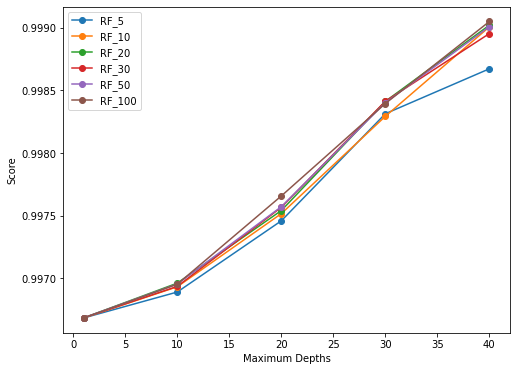

In [10]:
plt.figure(figsize=(8, 6))

for n in exploratory_estimators:
    plt.plot(exploratory_depths, [LinearForestRegressor(base_estimator=LinearRegression(), n_estimators=n, max_features='sqrt', max_depth=i).fit(X_train_scaled, y_train).score(X_train_scaled, y_train) for i in exploratory_depths], 
             marker= 'o', label='RF_'+str(n))
    
plt.xlabel('Maximum Depths')
plt.ylabel('Score')
plt.legend()
plt.show()

In [22]:
max_depth = [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50]
n_estimators = [5, 10, 15, 20, 25]
base_est = [LinearRegression(), Ridge(), Lasso(), ElasticNet(l1_ratio=0.25), ElasticNet(l1_ratio=0.5), ElasticNet(l1_ratio=0.75)]

In [23]:
models_list = []
for n in n_estimators:
    for i in max_depth:
        for est in base_est:
            models_list.append(LinearForestRegressor(base_estimator=est, max_features='sqrt', n_estimators=n, max_depth=i))

In [24]:
names_list = []

for n in n_estimators:
    for depth in max_depth:
        for est in base_est:
            if isinstance(est, LinearRegression):
                name = f'RERF_{depth}_{n}'
            elif isinstance(est, Ridge):
                name = f'RERF_{depth}_{n}_l2'
            elif isinstance(est, Lasso):
                name = f'RERF_{depth}_{n}_l1'
            elif isinstance(est, ElasticNet):
                name = f'RERF_{depth}_{n}_en_{est.l1_ratio}'
            else:
                raise ValueError('Unknown base estimator type')
            
            names_list.append(name)

In [25]:
metrics = regression(models_list, names_list, '../../../data/metrics/electricity_transformer/rerf.csv', X_train_scaled, y_train, X_validation_scaled, y_validation, metrics={})
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
RERF_1_5,0.542923,0.480992,0.293677,-38.943415
RERF_1_5_l2,0.211815,0.481155,0.294464,-38.800638
RERF_1_5_l1,0.222284,0.757814,1.029627,35.868075
RERF_1_5_en_0.25,5.229283,1.231778,0.762399,-38.105840
RERF_1_5_en_0.5,3.743871,1.219699,0.879256,-27.912008
...,...,...,...,...
RERF_50_25_l2,24.371627,0.211287,0.321399,52.115102
RERF_50_25_l1,17.301474,0.190921,0.327357,71.461861
RERF_50_25_en_0.25,19.006207,0.208314,0.510049,144.846634
RERF_50_25_en_0.5,19.319183,0.206169,0.444385,115.543690


In [26]:
metrics.sort_values(by='Validation_RMSE')

,Run_Time,Train_RMSE,Validation_RMSE,delta%
RERF_2_10,0.901172,0.480325,0.293398,-38.916777
RERF_1_10,0.618892,0.481036,0.293459,-38.994433
RERF_2_15,1.016315,0.480177,0.293513,-38.873975
RERF_4_5,0.770043,0.477401,0.293570,-38.506616
RERF_1_20,0.821961,0.481049,0.293578,-38.971286
...,...,...,...,...
RERF_1_5_l1,0.222284,0.757814,1.029627,35.868075
RERF_1_25_l1,0.656877,0.735609,1.042274,41.688567
RERF_1_15_l1,0.449526,0.736172,1.047084,42.233654
RERF_1_20_l1,0.547071,0.735019,1.051288,43.028710


Keep working with **RERF_2_10** that is the model with the random forest formed by 10 trees of maximum depth 2 and with the first regression solving the ordinary least squares problem

In [27]:
test =  pd.read_parquet('../../../data/model_input/test_sets/electricity_transformer.parquet')

In [28]:
y_test = test.OT_next
X_test = test.drop(columns=['date', 'OT_next'])

In [29]:
retrain = pd.concat([train, validation])

In [30]:
y_retrain = retrain.OT_next
X_retrain = retrain.drop(columns=['date', 'OT_next'])

In [31]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [32]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [69]:
model = LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt', max_depth=2, n_estimators=10).fit(X_retrain_scaled, y_retrain)

In [70]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 0.3261


In [71]:
dump(model, 'best_rerf.joblib')

['best_rerf.joblib']

In [72]:
with open('../../../data/metrics/electricity_transformer/final_RMSE.txt', 'a') as f:
    f.write('\nRERF, '+ str(rmse))

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_4068/2336408728.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],


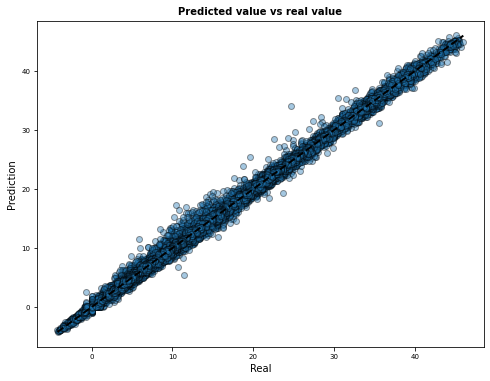

In [73]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain

plt.figure(figsize=(8, 6))

plt.scatter(y_retrain, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],
                'k--', color = 'black', lw=2)
plt.title('Predicted value vs real value', fontsize = 10, fontweight = "bold")
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.tick_params(labelsize = 7)

We can observe a difference with this plot from the random forest predictions that here we have predictions in the extremes more accurate